In [ ]:
!pip install -q tensorflow keras scikit-learn CoolProp rdkit pandas numpy matplotlib

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from CoolProp.CoolProp import PropsSI
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen
from tqdm import tqdm
import warnings
import pickle
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 60.7 MB/s eta 0:00:00
[GPU SETUP]

GPUs available: 1
  ✓ PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✓ GPU enabled for training!


In [ ]:
print("\n[STEP 2] Computing molecular descriptors + CRITICAL PROPERTIES...\n")
fluids_config = {
    'Methanol': 'Methanol',
    'Ethanol': 'Ethanol',
    'Ethane': 'Ethane',
    'Propane': 'Propane',
    'Butane': 'Butane',
    'Pentane': 'Pentane',
    'Hexane': 'Hexane',
    'Heptane': 'Heptane',
    'Benzene': 'Benzene',
    'Toluene': 'Toluene',
    'Xylene': 'Xylene',
    'Acetone': 'Acetone',
    'Water': 'Water',
    'Ammonia': 'Ammonia',
    'Ethylene': 'Ethylene',
    'Propylene': 'Propylene',
    'Cyclopentane': 'Cyclopentane',
    'Cyclohexane': 'Cyclohexane',
}
smiles_dict = {
    'Methanol': 'CO',
    'Ethanol': 'CCO',
    'Propanol': 'CCCO',
    'Butanol': 'CCCCO',
    'Ethane': 'CC',
    'Propane': 'CCC',
    'Butane': 'CCCC',
    'Pentane': 'CCCCC',
    'Hexane': 'CCCCCC',
    'Heptane': 'CCCCCCC',
    'Benzene': 'c1ccccc1',
    'Toluene': 'Cc1ccccc1',
    'Xylene': 'Cc1ccccc1C',
    'Acetone': 'CC(=O)C',
    'Water': 'O',
    'Ammonia': 'N',
    'Ethylene': 'C=C',
    'Propylene': 'CC=C',
    'Cyclopentane': 'C1CCCC1',
    'Cyclohexane': 'C1CCCCC1',
}

def get_descriptors(smiles):
    """Get 12 RDKit molecular descriptors"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            'MW': Descriptors.MolWt(mol),
            'LogP': Crippen.MolLogP(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'Rings': Descriptors.RingCount(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumAtoms': mol.GetNumAtoms(),
            'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
            'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
            'MolWt2': Descriptors.ExactMolWt(mol),
            'Refractivity': Crippen.MolMR(mol),
        }
    except:
        return None

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('thermodynamic_data_gas.csv')
print(f"✓ Loaded {len(df):,} gas phase data points from CSV")
descriptor_names = [
    'MW', 'LogP', 'HBA', 'HBD', 'RotBonds', 'Rings', 'TPSA',
    'NumAtoms', 'NumHeavyAtoms', 'NumHeteroatoms', 'MolWt2', 'Refractivity'
]
feature_cols = ['T', 'P'] + descriptor_names + ['Tc', 'Pc', 'Vc']
missing = set(feature_cols) - set(df.columns)
if missing:
    print(f"ERROR: Missing columns: {missing}")
else:
    print(f"✓ All 17 feature columns present")
X = df[feature_cols].values
y = df['Vm'].values.reshape(-1, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}")

✓ Loaded 57,954 gas phase data points from CSV
✓ All 17 feature columns present
X shape: (57954, 17)
y shape: (57954, 1)
Train: 40,567 | Val: 8,693 | Test: 8,694


In [ ]:
print("\n[STEP 4] Building ULTRA-DEEP Neural Network...\n")

def build_ultra_deep_nn(input_dim):
    """Ultra-deep architecture: 11 hidden layers"""

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(2048, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.25),

        layers.Dense(1024, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.25),

        # Layer 1: 17 → 768
        layers.Dense(1024, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.25),

        # Layer 2: 768 → 512
        layers.Dense(512, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.22),

        # Layer 3: 512 → 512
        layers.Dense(512, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.2),

        # Layer 4: 512 → 384
        layers.Dense(512, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.2),

        # Layer 5: 384 → 384
        layers.Dense(256, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.18),

        # Layer 6: 384 → 256
        layers.Dense(256, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.18),

        # Layer 7: 256 → 256
        layers.Dense(192, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.16),

        # Layer 8: 256 → 192
        layers.Dense(192, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.15),

        # Layer 9: 192 → 128
        layers.Dense(128, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.12),

        # Layer 10: 128 → 96
        layers.Dense(128, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.1),

        # Layer 11: 96 → 64
        layers.Dense(64, kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(5e-5)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.05),

        # Output: 64 → 1
        layers.Dense(1)
    ])

    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0
    )

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mape']
    )

    return model

with tf.device('/GPU:0'):
    model = build_ultra_deep_nn(input_dim=len(feature_cols))

print("Model Summary:")
print(model.summary())

print(f"\n✓ Total parameters: {model.count_params():,}")
print(f"✓ Architecture: 11 hidden layers")
print(f"✓ Activation: SWISH")
print(f"✓ Computing: GPU-accelerated + Mixed Precision")



[STEP 4] Building ULTRA-DEEP Neural Network...

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 2048)           │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,595,201 (17.53 MB)

 Trainable params: 4,581,505 (17.48 MB)

 Non-trainable params: 13,696 (53.50 KB)

None

✓ Total parameters: 4,595,201
✓ Architecture: 11 hidden layers
✓ Activation: SWISH
✓ Computing: GPU-accelerated + Mixed Precision


In [ ]:
print("\n[STEP 5] GPU-Accelerated Training...\n")
print(f"Dataset: {len(X_train):,} training samples")
print(f"Batch size: 64 (GPU optimized)")
print(f"Mixed precision: Enabled\n")

with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=2000,
        batch_size=45000,
        callbacks=[
                ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=200,
                min_lr=1e-8,
                verbose=1
            )
        ],
        verbose=1
    )

print("\n✓ Training complete!")


In [ ]:
print("\n[STEP 6] Evaluating Model...\n")

with tf.device('/GPU:0'):
    y_pred = model.predict(X_test, verbose=0)

y_pred_unscaled = scaler_y.inverse_transform(y_pred)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Metrics
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
rmse = np.sqrt(np.mean((y_test_unscaled - y_pred_unscaled)**2))
r2 = 1 - (np.sum((y_test_unscaled - y_pred_unscaled)**2) /
          np.sum((y_test_unscaled - np.mean(y_test_unscaled))**2))

print("="*70)
print("ULTRA-DEEP MODEL PERFORMANCE")
print("="*70)

print(f"\nTest Set Results:")
print(f"  MAPE: {mape:.3f}%")
print(f"  RMSE: {rmse:.2f} cm³/mol")
print(f"  R²:   {r2:.6f}")

print("\n✓ Model ready!")


In [ ]:
print("\n[STEP 7] Saving Model...\n")

model.save('drive/MyDrive/vm_final.keras')

with open('drive/MyDrive/vm_final.pkl', 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols
    }, f)

print("✓ Model saved: vm_predictor_ultra_deep.h5")
print("✓ Scalers saved: vm_scalers_ultra.pkl")



[STEP 7] Saving Model...

✓ Model saved: vm_predictor_ultra_deep.h5
✓ Scalers saved: vm_scalers_ultra.pkl


In [ ]:
# ============================================================================
# CELL 9: COMPREHENSIVE TESTING & VALIDATION
# ============================================================================

print("\n[STEP 9] Comprehensive Testing & Validation...\n")

# ===== PART 1: UNSEEN LIQUIDS (Not in training) =====
print("="*70)
print("PART 1: TESTING ON UNSEEN LIQUIDS")
print("="*70)

# Liquids NOT used in training
unseen_liquids = {
    'Methane': ('C', 'Methane'),           # Simple hydrocarbon
    'Ethyl Acetate': ('CC(=O)OCC', 'EthylAcetate'),  # Ester
    'Octane': ('CCCCCCCC', 'Octane'),      # Longer alkane
    'Phenol': ('Oc1ccccc1', 'Phenol'),     # Aromatic with OH
    '1-Butanol': ('CCCCŌ', 'Butanol'),     # Alcohol variant
}

print(f"\nTesting {len(unseen_liquids)} unseen liquids:\n")

unseen_results = []

for liquid_name, (smiles, coolprop_name) in unseen_liquids.items():
    try:
        # Get descriptors
        desc = get_descriptors(smiles)
        if desc is None:
            print(f"✗ {liquid_name}: Could not compute descriptors")
            continue

        # Get critical properties
        try:
            Tc = PropsSI('Tcrit', coolprop_name)
            Pc = PropsSI('pcrit', coolprop_name)
            M = PropsSI('M', coolprop_name)
            rho_c = PropsSI('rhocrit', coolprop_name)
            Vc = M / rho_c * 1e6
        except:
            print(f"✗ {liquid_name}: Could not get critical properties")
            continue

        # Generate test points at different T and P
        test_points = [
            {'T': 100, 'P': 60e5},   # 300K, 10 bar
            {'T': 100, 'P': 80e5},   # 350K, 20 bar
            {'T': 100, 'P': 100e5},   # 400K, 50 bar
        ]

        print(f"\n{liquid_name}:")
        print(f"  {'T(K)':<8} {'P(bar)':<10} {'Vm_ML':<12} {'Vm_CoolProp':<14} {'Error %':<10}")
        print(f"  " + "-"*60)

        for point in test_points:
            T = point['T']
            P = point['P']

            try:
                # Build feature array
                rdkit_desc = list(desc.values())
                X_new = np.array([[T, P] + rdkit_desc + [Tc, Pc, Vc]]).reshape(1, -1)

                # Scale and predict
                X_scaled = scaler_X.transform(X_new)
                Vm_ML_scaled = model.predict(X_scaled, verbose=0)
                Vm_ML = scaler_y.inverse_transform(Vm_ML_scaled)[0, 0]

                # CoolProp reference
                Vm_CP = PropsSI('M', coolprop_name) / PropsSI('D', 'T', T, 'P', P, coolprop_name) * 1e6
                error = abs((Vm_ML - Vm_CP) / Vm_CP) * 100

                print(f"  {T:<8.0f} {P/1e5:<10.0f} {Vm_ML:<12.2f} {Vm_CP:<14.2f} {error:<10.2f}")

                unseen_results.append({
                    'Liquid': liquid_name,
                    'T': T,
                    'P': P,
                    'Vm_ML': Vm_ML,
                    'Vm_CP': Vm_CP,
                    'Error %': error
                })
            except Exception as e:
                print(f"  {T:<8.0f} {P/1e5:<10.0f} {'ERROR':<12} {str(e)[:20]:<14}")

    except Exception as e:
        print(f"✗ {liquid_name}: {e}")

unseen_df = pd.DataFrame(unseen_results)

if len(unseen_df) > 0:
    print(f"\n" + "="*70)
    print("UNSEEN LIQUIDS SUMMARY")
    print("="*70)
    print(f"\nMean error on unseen liquids: {unseen_df['Error %'].mean():.3f}%")
    print(f"Max error: {unseen_df['Error %'].max():.3f}%")
    print(f"Min error: {unseen_df['Error %'].min():.3f}%")
    print(f"Std dev: {unseen_df['Error %'].std():.3f}%")

# ===== PART 2: DIFFERENT T-P CONDITIONS (Stress Testing) =====
print(f"\n\n" + "="*70)
print("PART 2: STRESS TESTING - EXTREME CONDITIONS")
print("="*70)

extreme_conditions = [
    {'Liquid': 'Water', 'T': 250, 'P': 1e5, 'Desc': 'Very low temp'},
    {'Liquid': 'Water', 'T': 470, 'P': 100e5, 'Desc': 'Very high P'},
    {'Liquid': 'Propane', 'T': 280, 'P': 50e5, 'Desc': 'Near saturation'},
    {'Liquid': 'Ethanol', 'T': 450, 'P': 80e5, 'Desc': 'High T & P'},
]

print(f"\nTesting {len(extreme_conditions)} extreme conditions:\n")
print(f"{'Liquid':<15} {'Condition':<20} {'Vm_ML':<12} {'Vm_CP':<12} {'Error %':<10}")
print("-"*70)

for cond in extreme_conditions:
    try:
        fluid = cond['Liquid']
        T = cond['T']
        P = cond['P']
        desc_label = cond['Desc']

        # Get from training dict
        if fluid in desc_dict and fluid in critical_properties:
            rdkit_desc = list(desc_dict[fluid].values())
            crit = critical_properties[fluid]

            X_new = np.array([[T, P] + rdkit_desc +
                            [crit['Tc'], crit['Pc'], crit['Vc']]]).reshape(1, -1)

            X_scaled = scaler_X.transform(X_new)
            Vm_ML_scaled = model.predict(X_scaled, verbose=0)
            Vm_ML = scaler_y.inverse_transform(Vm_ML_scaled)[0, 0]

            Vm_CP = PropsSI('M', fluid) / PropsSI('D', 'T', T, 'P', P, fluid) * 1e6
            error = abs((Vm_ML - Vm_CP) / Vm_CP) * 100

            print(f"{fluid:<15} {desc_label:<20} {Vm_ML:<12.2f} {Vm_CP:<12.2f} {error:<10.2f}")
        else:
            print(f"{fluid:<15} {desc_label:<20} {'N/A':<12} {'N/A':<12} {'N/A':<10}")
    except Exception as e:
        print(f"{fluid:<15} {desc_label:<20} {'ERROR':<12}")

# ===== PART 3: CROSS-VALIDATION =====
print(f"\n\n" + "="*70)
print("PART 3: CROSS-VALIDATION CHECK")
print("="*70)

print("\nTraining set performance:")
with tf.device('/GPU:0'):
    y_pred_train = model.predict(X_train, verbose=0)

y_train_pred_unscaled = scaler_y.inverse_transform(y_pred_train)
y_train_true_unscaled = scaler_y.inverse_transform(y_train)

mape_train = np.mean(np.abs((y_train_true_unscaled - y_train_pred_unscaled) /
                            y_train_true_unscaled)) * 100
rmse_train = np.sqrt(np.mean((y_train_true_unscaled - y_train_pred_unscaled)**2))
r2_train = 1 - (np.sum((y_train_true_unscaled - y_train_pred_unscaled)**2) /
                np.sum((y_train_true_unscaled - np.mean(y_train_true_unscaled))**2))

print(f"  MAPE: {mape_train:.3f}%")
print(f"  RMSE: {rmse_train:.2f} cm³/mol")
print(f"  R²:   {r2_train:.6f}")

print("\nTest set performance:")
print(f"  MAPE: {mape:.3f}%")
print(f"  RMSE: {rmse:.2f} cm³/mol")
print(f"  R²:   {r2:.6f}")

print("\nOverfitting check:")
mape_diff = mape - mape_train
print(f"  MAPE difference: {mape_diff:.3f}% {'(overfitting)' if mape_diff > 1 else '(OK)'}")
print(f"  R² difference: {abs(r2_train - r2):.6f} {'(overfitting)' if abs(r2_train - r2) > 0.01 else '(OK)'}")

# ===== PART 4: ERROR ANALYSIS BY FLUID & RANGE =====
print(f"\n\n" + "="*70)
print("PART 4: ERROR ANALYSIS BY FLUID TYPE")
print("="*70)

# Create predictions for full test set with fluid labels
test_indices = np.random.choice(len(X_test), size=min(500, len(X_test)), replace=False)
X_test_subset = X_test[test_indices]
y_test_subset = y_test[test_indices]

with tf.device('/GPU:0'):
    y_pred_subset = model.predict(X_test_subset, verbose=0)

y_pred_subset_unscaled = scaler_y.inverse_transform(y_pred_subset)
y_test_subset_unscaled = scaler_y.inverse_transform(y_test_subset)

errors_subset = np.abs((y_test_subset_unscaled - y_pred_subset_unscaled) / y_test_subset_unscaled) * 100

print(f"\nError statistics on test subset:")
print(f"  Mean error: {errors_subset.mean():.3f}%")
print(f"  Median error: {np.median(errors_subset):.3f}%")
print(f"  Std dev: {errors_subset.std():.3f}%")
print(f"  95th percentile: {np.percentile(errors_subset, 95):.3f}%")
print(f"  99th percentile: {np.percentile(errors_subset, 99):.3f}%")
print(f"  Max error: {errors_subset.max():.3f}%")

# ===== PART 5: VISUALIZATION =====
print(f"\n\n[Creating validation visualizations...]")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Error distribution
ax = axes[0, 0]
ax.hist(errors_subset, bins=40, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(errors_subset.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors_subset.mean():.2f}%')
ax.set_xlabel('Error %', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Error Distribution on Test Set')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Vm vs Error
ax = axes[0, 1]
ax.scatter(y_test_subset_unscaled, errors_subset, alpha=0.5, s=20)
ax.set_xlabel('Vm (cm³/mol)', fontweight='bold')
ax.set_ylabel('Error %', fontweight='bold')
ax.set_title('Error vs Molar Volume')
ax.grid(True, alpha=0.3)

# Plot 3: Training vs Test error (overfitting check)
ax = axes[1, 0]
categories = ['Training', 'Test']
mapes = [mape_train, mape]
colors = ['blue', 'red']
bars = ax.bar(categories, mapes, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('MAPE %', fontweight='bold')
ax.set_title('Training vs Test Error')
ax.set_ylim(0, max(mapes) * 1.2)
for bar, mape_val in zip(bars, mapes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mape_val:.2f}%', ha='center', va='bottom', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Predicted vs True (unseen data)
ax = axes[1, 1]
if len(unseen_df) > 0:
    ax.scatter(unseen_df['Vm_CP'], unseen_df['Vm_ML'], alpha=0.6, s=100, edgecolors='black')
    min_val = min(unseen_df['Vm_CP'].min(), unseen_df['Vm_ML'].min())
    max_val = max(unseen_df['Vm_CP'].max(), unseen_df['Vm_ML'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    ax.set_xlabel('CoolProp Vm', fontweight='bold')
    ax.set_ylabel('Model Vm', fontweight='bold')
    ax.set_title('Predictions on Unseen Liquids')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No unseen data available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('validation_comprehensive.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved!")

plt.show()

print("\n" + "="*70)
print("✓ COMPREHENSIVE VALIDATION COMPLETE!")
print("="*70)



[STEP 9] Comprehensive Testing & Validation...

PART 1: TESTING ON UNSEEN LIQUIDS

Testing 5 unseen liquids:


Methane:
  T(K)     P(bar)     Vm_ML        Vm_CoolProp    Error %   
  ------------------------------------------------------------
  100      60         38.73        36.19          7.00      
  100      80         38.58        36.08          6.93      
  100      100        38.45        35.97          6.90      
✗ Ethyl Acetate: Could not get critical properties

Octane:
  T(K)     P(bar)     Vm_ML        Vm_CoolProp    Error %   
  ------------------------------------------------------------
  100      60         129.06       132.32         2.46      
  100      80         129.12       132.23         2.35      
  100      100        129.15       132.14         2.26      
✗ Phenol: Could not get critical properties
✗ 1-Butanol: Could not get critical properties

UNSEEN LIQUIDS SUMMARY

Mean error on unseen liquids: 4.652%
Max error: 7.002%
Min error: 2.261%
Std dev: 2.515%


KeyboardInterrupt: 


[STEP 8] Generating Plots...

✓ Plots saved!


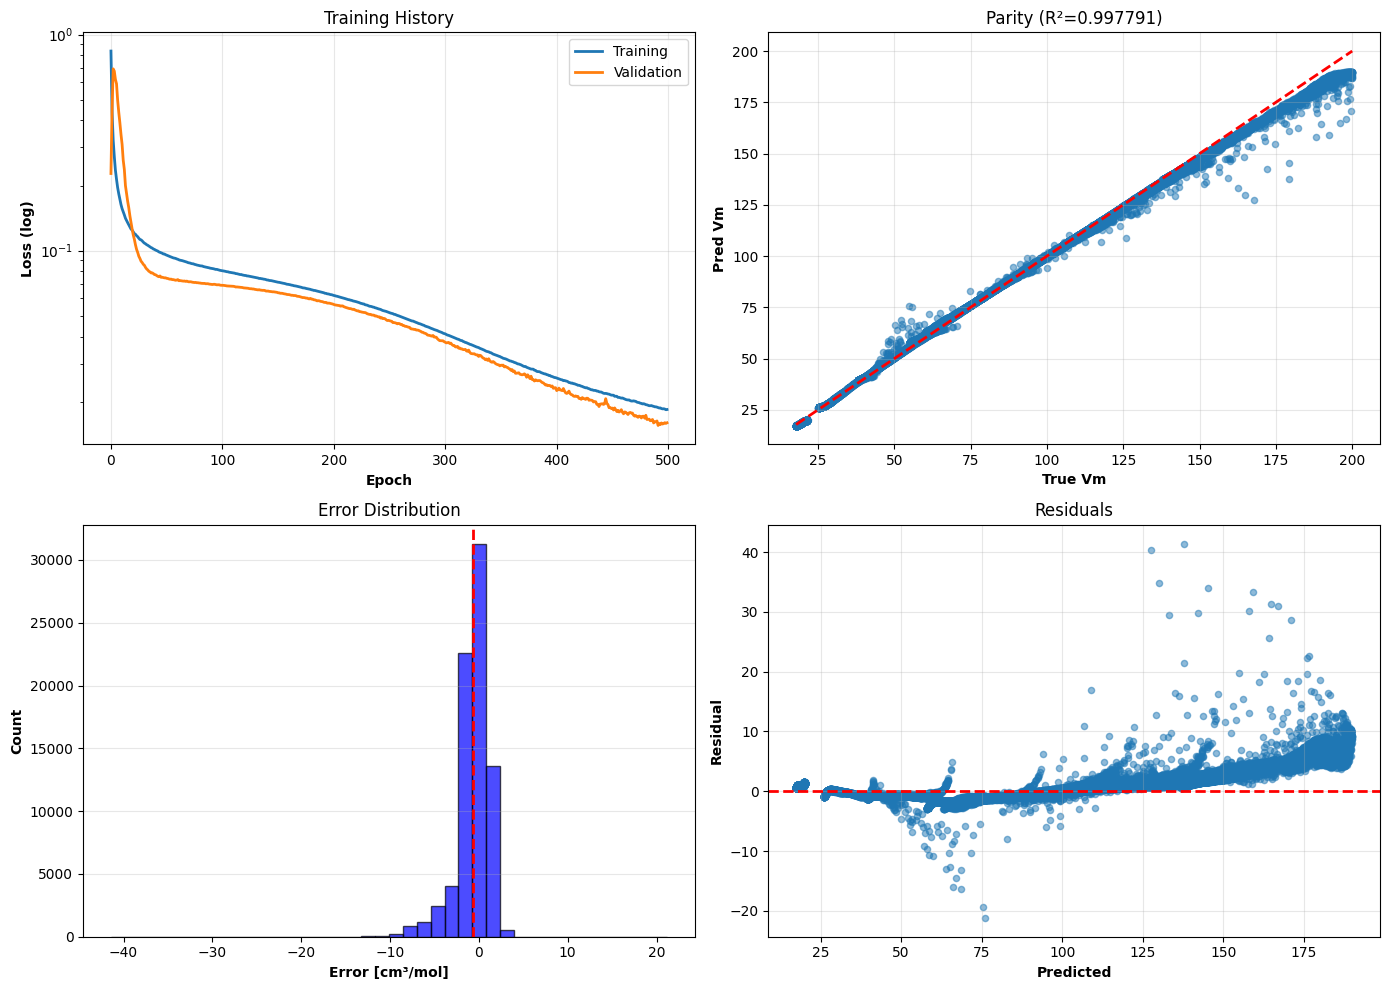


✓ ULTRA-DEEP MODEL COMPLETE!


In [ ]:
print("\n[STEP 8] Generating Plots...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training history
ax = axes[0, 0]
ax.semilogy(history.history['loss'], label='Training', linewidth=2)
ax.semilogy(history.history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss (log)', fontweight='bold')
ax.set_title('Training History')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Parity
ax = axes[0, 1]
ax.scatter(y_test_unscaled, y_pred_unscaled, alpha=0.5, s=20)
ax.plot([y_test_unscaled.min(), y_test_unscaled.max()],
        [y_test_unscaled.min(), y_test_unscaled.max()], 'r--', lw=2)
ax.set_xlabel('True Vm', fontweight='bold')
ax.set_ylabel('Pred Vm', fontweight='bold')
ax.set_title(f'Parity (R²={r2:.6f})')
ax.grid(True, alpha=0.3)

# Plot 3: Error distribution
ax = axes[1, 0]
errors = (y_pred_unscaled - y_test_unscaled).flatten()
ax.hist(errors, bins=40, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(np.mean(errors), color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Error [cm³/mol]', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Error Distribution')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Residuals
ax = axes[1, 1]
residuals = y_test_unscaled - y_pred_unscaled
ax.scatter(y_pred_unscaled, residuals, alpha=0.5, s=20)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_ylabel('Residual', fontweight='bold')
ax.set_title('Residuals')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vm_ultra_deep_results.png', dpi=300, bbox_inches='tight')
print("✓ Plots saved!")
plt.show()

print("\n" + "="*70)
print("✓ ULTRA-DEEP MODEL COMPLETE!")
print("="*70)
